# Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

### Importing Skin Cancer Data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
# Unzip provided dataset
dataset_zip = "CNN_assignment_Dataset.zip"

from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile(dataset_zip, 'r') as zObject:
    zObject.extractall(path="dataset")

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training Image count: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Testing Image count: ", image_count_test)

Training Image count:  2239
Testing Image count:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = "training",
                                  image_size = (img_height, img_width),
                                  batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = "validation",
                                  image_size = (img_height, img_width),
                                  batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

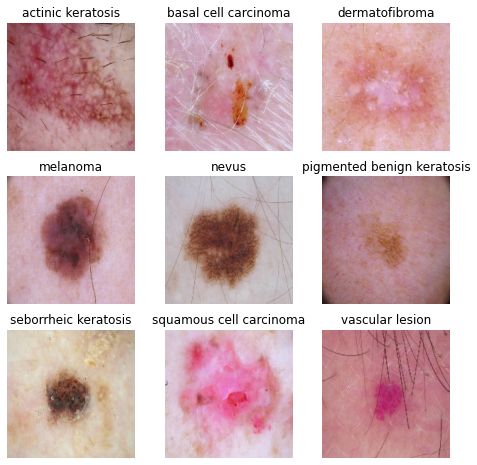

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

# Visualize image 
plt.figure(figsize=(8,8))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

- Input is 180 x 180 x 3 images
- Using 2 Convolution layers with 16 and 32 filters, filter size 3 x 3
- Using Max pooling layers of size 2 x 2 after both conv layers
- Adding a flattening layer followed by dense\ fully connected layers
- Using relu activation for all hidden layers
- at last a final output layer with 9 nodes for softmax classification

In [12]:
### CNN Model

model = Sequential()

# Rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1/.255, input_shape=(180,180,3)))

# Convolution layer 1
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Convolution Layer 2
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer 1
model.add(layers.Dense(32,activation='relu'))

# Dense Layer 2
model.add(layers.Dense(16,activation='relu'))

# Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 59168)             0

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 59168)             0

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 19s 247ms/step - loss: 117.2561 - accuracy: 0.1607 - val_loss: 2.1788 - val_accuracy: 0.1991
Epoch 2/20
56/56 [==============================] - 13s 238ms/step - loss: 2.1867 - accuracy: 0.2137 - val_loss: 2.1421 - val_accuracy: 0.1633
Epoch 3/20
56/56 [==============================] - 14s 249ms/step - loss: 2.1298 - accuracy: 0.2210 - val_loss: 2.0972 - val_accuracy: 0.1879
Epoch 4/20
56/56 [==============================] - 14s 257ms/step - loss: 2.0389 - accuracy: 0.2450 - val_loss: 2.0573 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 16s 281ms/step - loss: 1.9177 - accuracy: 0.2768 - val_loss: 2.0223 - val_accuracy: 0.2282
Epoch 6/20
56/56 [==============================] - 20s 367ms/step - loss: 1.7269 - accuracy: 0.3923 - val_loss: 1.9769 - val_accuracy: 0.2975
Epoch 7/20
56/56 [==============================] - 17s 300ms/step - loss: 1.5156 - accuracy: 0.4860 - val_loss: 2.0544 - val_accuracy: 0.27

### Visualizing training results

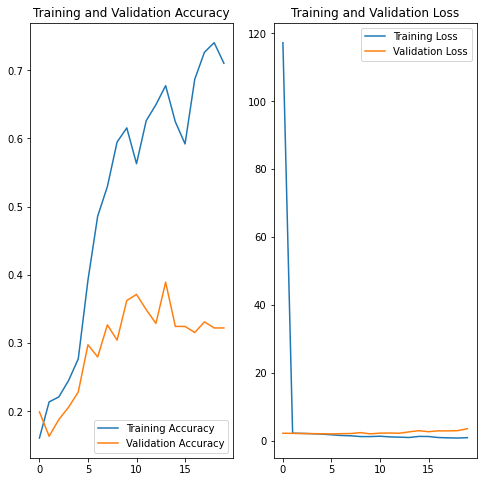

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observations
- Training accuracy is 71%.
- Validation accuracy is 32%.
- Validation accuracy is much lower than training accuracy.
- Training accuracy is increasing with each epoch\ iteration, but not with testing data.
- loss on training dataset is decreasing with each epoch, but not on validation dataset.
- all above shows clear case of model overfitting.

#### Learning
- To resolve overfitting, lets try adding some drop out layers and augumentation layers

Augumentation layer adds randomness in data, by flipping, rotating the images

In [17]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
  ]
)

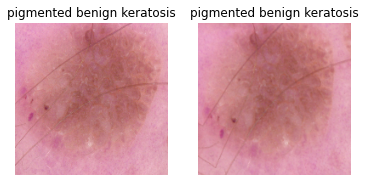

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
for image, label in train_ds.take(1):
        ax = plt.subplot(1, 2, 1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')
        
        augmented = data_augmentation(image)
        ax = plt.subplot(1, 2, 2)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

### Create the model, compile and train the model

Creating second model with adding some drop out layers and augumentation layers

In [19]:
### CNN Model

model = Sequential()

# Augumentation layer
model.add(data_augmentation)

# Rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1/.255, input_shape=(180,180,3)))

# Convolution layer 1
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

# Convolution Layer 2
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer 1
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dropout(0.3))

# Dense Layer 2
model.add(layers.Dense(16,activation='relu'))

# Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 32)        4640      
                                                      

### Compiling the model

In [20]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 32)        4640      
                                                      

### Training the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 17s 272ms/step - loss: 229.8734 - accuracy: 0.1853 - val_loss: 2.1704 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 15s 269ms/step - loss: 2.1634 - accuracy: 0.1964 - val_loss: 2.1456 - val_accuracy: 0.1969
Epoch 3/20
56/56 [==============================] - 15s 274ms/step - loss: 2.1398 - accuracy: 0.1618 - val_loss: 2.1234 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 16s 289ms/step - loss: 2.1189 - accuracy: 0.1607 - val_loss: 2.1046 - val_accuracy: 0.2036
Epoch 5/20
56/56 [==============================] - 17s 301ms/step - loss: 2.1010 - accuracy: 0.1981 - val_loss: 2.0880 - val_accuracy: 0.2103
Epoch 6/20
56/56 [==============================] - 18s 317ms/step - loss: 2.0860 - accuracy: 0.1942 - val_loss: 2.0742 - val_accuracy: 0.2103
Epoch 7/20
56/56 [==============================] - 19s 338ms/step - loss: 2.0732 - accuracy: 0.2065 - val_loss: 2.0635 - val_accuracy: 0.21

### Visualizing the results

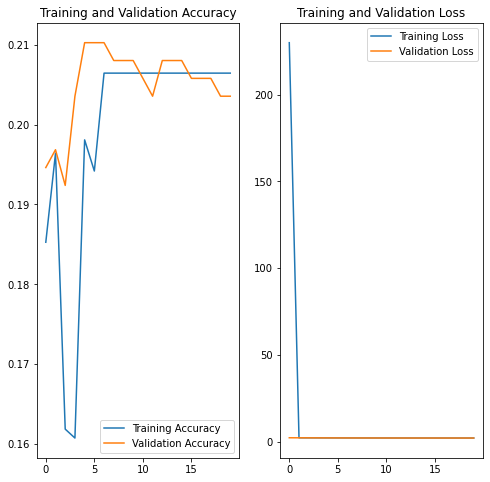

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations
- Training accuracy is 20%.
- Validation accuracy is 20%.
- Validation accuracy is similar to training accuracy.
- loss on training dataset is almost same as on validation dataset.
- all above shows model is not performing well at all.
- this shows underfitting, and needs more training.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [24]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

<BarContainer object of 9 artists>

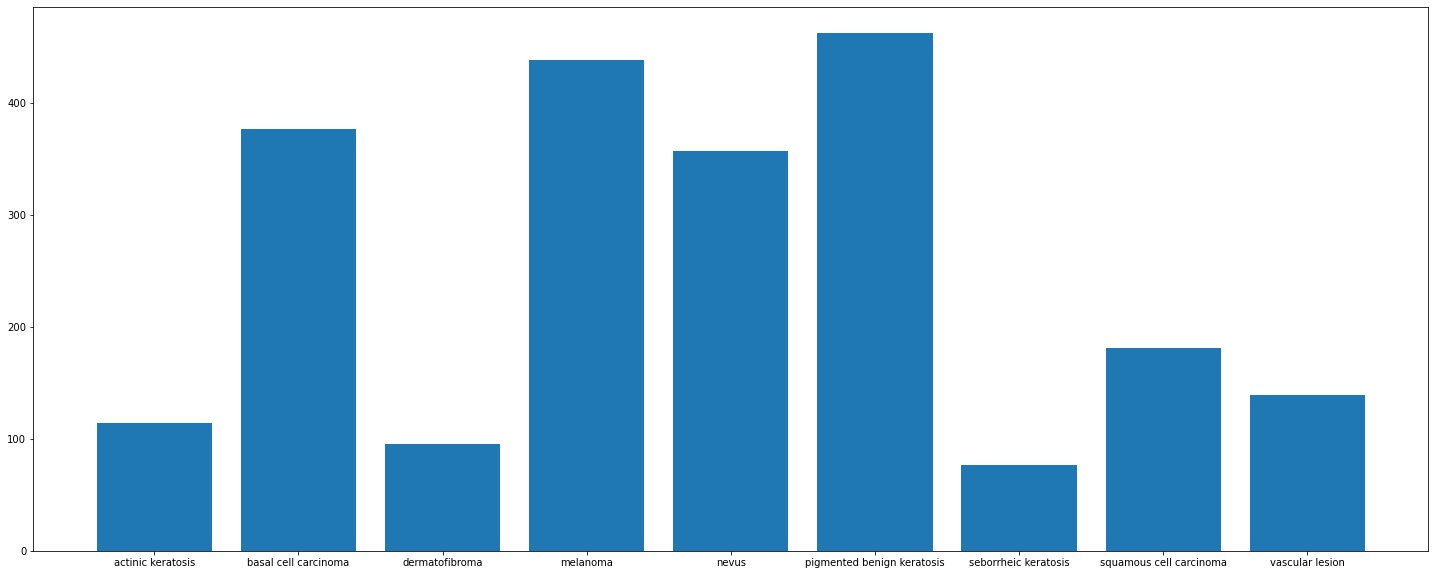

In [26]:
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### Findings
- We can see data is not complete, and there is a class imbalance problem.
- 'Pigmented benign keratosis' class has highest samples in the given dataset.
- 'dermatofibroma', 'seborrheic keratosis' have almost similar samples.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=("dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x199AF157070>: 100%|█| 500/500 [00:02<00:00, 172.33 Samples


Initialised with 376 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x199961E0490>: 100%|█| 500/500 [00:03<00:00, 158.59 Samples


Initialised with 95 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x199853ACE80>: 100%|█| 500/500 [00:03<00:


Initialised with 438 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1998F4020A0>: 100%|█| 500/500 [00:16<00:00, 30.97 Samples


Initialised with 357 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1998F459970>: 100%|█| 500/500 [00:15<00:00, 31.78 Samples/


Initialised with 462 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1998F280B20>: 100%|█| 500/500 [00:03<00:


Initialised with 77 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x199964967C0>: 100%|█| 500/500 [00:08<00


Initialised with 181 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x199964771F0>: 100%|█| 500/500 [00:03<00:


Initialised with 139 image(s) found.
Output directory set to dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1998F2217C0>: 100%|█| 500/500 [00:03<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_07a6e5d4-64e6-4fe6-862a-36f8b14501b5.jpg',
 'dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_25803ce7-833b-4791-abb5-dbfbed1971bf.jpg',
 'dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_39f242cb-abe7-4633-b7da-42263659e276.jpg',
 'dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6e964876-e2eb-435b-907b-08cfff8ed238.jpg',
 'dataset\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_72185b1c-86fb-479d-8b5e-00569e71d32c.jpg',
 'dataset\\Skin cancer IS

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [38]:
data_dir_train="dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
### CNN Model

model = Sequential()

# Rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1/.255, input_shape=(180,180,3)))

# Convolution layer, Max pool layer, dropout layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.2))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.2))

# Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [51]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                 

#### Train your model

In [52]:
# lets train model for 30 epochs and analyze the results
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/30
169/169 [==============================] - 185s 1s/step - loss: 9.9558 - accuracy: 0.1614 - val_loss: 2.1277 - val_accuracy: 0.1886
Epoch 2/30
169/169 [==============================] - 83s 493ms/step - loss: 2.0223 - accuracy: 0.2270 - val_loss: 2.1042 - val_accuracy: 0.1990
Epoch 3/30
169/169 [==============================] - 97s 577ms/step - loss: 1.8894 - accuracy: 0.2689 - val_loss: 1.8398 - val_accuracy: 0.3363
Epoch 4/30
169/169 [==============================] - 165s 976ms/step - loss: 1.7538 - accuracy: 0.3190 - val_loss: 1.7488 - val_accuracy: 0.3007
Epoch 5/30
169/169 [==============================] - 161s 955ms/step - loss: 1.7333 - accuracy: 0.3316 - val_loss: 1.6950 - val_accuracy: 0.3370
Epoch 6/30
169/169 [==============================] - 103s 608ms/step - loss: 1.6647 - accuracy: 0.3509 - val_loss: 1.7595 - val_accuracy: 0.3326
Epoch 7/30
169/169 [==============================] - 132s 784ms/step - loss: 1.6185 - accuracy: 0.3731 - val_loss: 1.6131 - val_

#### Visualize the model results

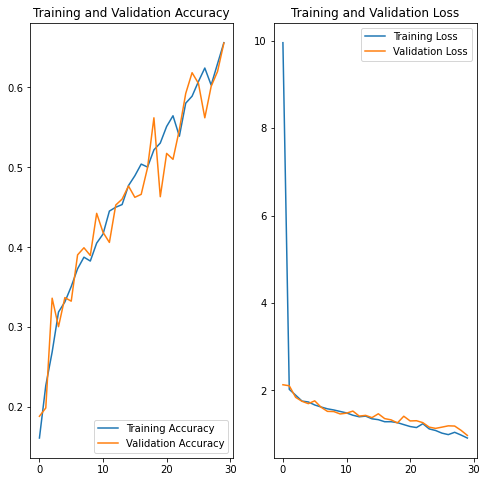

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations (after first 30 epochs)

- Training accuracy is 65%.
- Validation accuracy is 65%.
- Validation accuracy is similar to training accuracy, and increasing with each epoch.
- loss on training dataset is following same path as on validation dataset.
- Model is performing decently well, and not overfitting or underfitting now.
- More layers can be added, or different layer combinations can be attempted, or more epochs can be run to improve accuracy

#### Train model for 20 more epochs

In [54]:
# train same model again for 20 more epochs to see if accuracy improves
history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  batch_size=32
)

Epoch 1/20
169/169 [==============================] - 139s 826ms/step - loss: 0.8850 - accuracy: 0.6576 - val_loss: 1.0691 - val_accuracy: 0.6281
Epoch 2/20
169/169 [==============================] - 183s 1s/step - loss: 0.8866 - accuracy: 0.6732 - val_loss: 1.1982 - val_accuracy: 0.5553
Epoch 3/20
169/169 [==============================] - 164s 969ms/step - loss: 0.8800 - accuracy: 0.6767 - val_loss: 1.0064 - val_accuracy: 0.6563
Epoch 4/20
169/169 [==============================] - 186s 1s/step - loss: 0.9199 - accuracy: 0.6738 - val_loss: 1.0402 - val_accuracy: 0.6496
Epoch 5/20
169/169 [==============================] - 201s 1s/step - loss: 0.7866 - accuracy: 0.7112 - val_loss: 0.9158 - val_accuracy: 0.6815
Epoch 6/20
169/169 [==============================] - 207s 1s/step - loss: 0.7847 - accuracy: 0.7073 - val_loss: 0.9304 - val_accuracy: 0.6800
Epoch 7/20
169/169 [==============================] - 239s 1s/step - loss: 0.7755 - accuracy: 0.7103 - val_loss: 0.9000 - val_accuracy: 

#### Visualize the model results for last 20 epochs

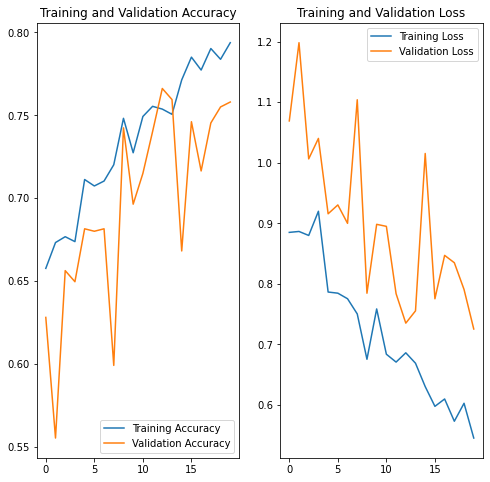

In [56]:
# Visualising results from last 20 epochs only
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observations (after total 50 epochs)

- Both Training and validation accuracy has gone up to 79% and 76% respectively.
- Loss is constantly reducing in both training and validation for each epoch.
- Model performance has improved with more training.
- Underfitting, overfitting issues no longer present.
- Model is performing decently.

------------------